In [1]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import seaborn as sns
from tqdm.notebook import tqdm
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, DMatrix
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor,Pool
from catboost import Pool, cv

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.utils import shuffle

---

## Соревнование 1.4.3

В файле `houses_train.csv` представлен набор данных про квартиры в городе Сиэтл, штат Вашингтон. Задача — предсказать цену на жилье по имеющимся данным.

Данные имеют следующие столбцы.

- `id` — идентификационный номер жилья
- `date` — дата продажи дома
- `price` — цена
- `bedrooms` — количество спален
- `bathrooms` — количество ванных комнат, где .5 означает комнату с туалетом, но без душа
- `sqft_living` — площадь жилья
- `sqft_lot` — площадь участка
- `floors` — количество этажей
- `waterfront` — видна ли набережная
- `view` — насколько хороший вид
- `condition` — индекс от 1 от 5, отвечающий за состояние квартиры
- `grade` — 1 до 13, 1-3 соответствует плохому уровню строительства и дизайна, 3-7 — средний уровень, 11-13 — высокий.
- `sqft_above` — жилая площадь над уровнем земли
- `sqft_basement` — жилая площадь под уровнем земли
- `yr_built` — год постройки жилья
- `yr_renovated` — год последней реконструкции жилья
- `zipcode` — почтовый индекс
- `lat` — широта
- `long` — долгота
- `sqft_living15` — средняя площадь жилья ближайших 15-и соседей
- `sqft_lot15` — средняя площадь участка ближайших 15-и соседей


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS/ML/4.3 ДЗ/houses_train.csv')
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3392,20151013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,18295,20151209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,14569,20151209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,14081,20160218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,6725,20150627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,20922,20160126T000000,429000.0,3,2.00,1490,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
15622,13963,20151014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15623,9850,20150521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15624,13975,20160223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


### Генерация признаков

Вспомните советы про признаки с типом "время" и сгенерируйте признак, производный от (`yr_built` или `yr_renovated`) и `date`.

Нам надо будет создать признак, который будет обозначать время между date and (yr_built, yr_renovated). То есть между последним строительством/реконструции жилья перед покупкой и датой самой покупки. Давайте также нам надо разбить дату на год, месяц, сезон.

In [5]:
df=data.copy()
all_time=list(map(lambda x: (x[-6:-1]),np.array(df.date)))#оставили только само время, а не дату
all(np.array(all_time)=="00000")#как хорошо видно времени вообще нет
df.date=list(map(lambda x: str(x[0:8]),np.array(df.date)))
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3392,20151013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,18295,20151209,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,14569,20151209,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,14081,20160218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,6725,20150627,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819


In [6]:
year=list(map(lambda x: int(x[0:4]),np.array(df.date)))
month=list(map(lambda x: int(x[4:6]),np.array(df.date)))
day=list(map(lambda x: int(x[6:8]),np.array(df.date)))
df['date_year']=year
df['date_month']=month
date_season=(np.array(month))//3
date_season[date_season==4]*=0
df['date_season']=date_season
diff=list(df.apply(lambda x: np.abs(x.date_year-x.yr_built if x.yr_renovated==0 or x.yr_renovated>x.date_year else \
                                    x.date_year-x.yr_renovated), axis=1))
df['diff_yr_change_date']=diff
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_year,date_month,date_season,diff_yr_change_date
0,3392,20151013,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,98178,47.5112,-122.257,1340,5650,2015,10,3,60
1,18295,20151209,538000.0,3,2.25,2570,7242,2.0,0,0,...,1991,98125,47.7210,-122.319,1690,7639,2015,12,0,24
2,14569,20151209,604000.0,4,3.00,1960,5000,1.0,0,0,...,0,98136,47.5208,-122.393,1360,5000,2015,12,0,50
3,14081,20160218,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,98074,47.6168,-122.045,1800,7503,2016,2,0,29
4,6725,20150627,257500.0,3,2.25,1715,6819,2.0,0,0,...,0,98003,47.3097,-122.327,2238,6819,2015,6,2,20


Найдите точку в центре города Сиэтл. Вычислите новый признак "расстояние до центра". Также поверните координаты на $45$ градусов.

In [7]:
def rotate(point,central_point, angle):
    lat,long = point
    lat_central,long_central=central_point
    
    diff_long = long-long_central
    diff_lat = lat-lat_central

    cos_angle = np.cos(angle*np.pi/180)
    sin_angle = np.sin(angle*np.pi/180)

    rotate_long = diff_long * cos_angle - diff_lat * sin_angle
    rotate_lat = diff_long * sin_angle + diff_lat * cos_angle

    return ([rotate_lat+lat_central,rotate_long + long_central])

In [8]:
rotate((48.856663, 2.351556),(43.591814, 1.441828),45)#повернули Париж вокруг Тулузы, работает корректно. Получили Бургбарре

[47.95789926765849, -1.6377075919879367]

In [9]:
import geopy.distance
lat_Seattle=47.617004
long_Seattle=-122.343506
coords_Seattle=(lat_Seattle,long_Seattle)
df['distance_to_center']=df.apply(lambda x: geopy.distance.distance(coords_Seattle, (x.lat,x.long)).km, axis=1)

df['lat_rotate_45']=df.apply(lambda x: rotate((x.lat,x.long),coords_Seattle,45)[0], axis=1)
df['long_rotate_45']=df.apply(lambda x: rotate((x.lat,x.long),coords_Seattle,45)[1], axis=1)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,date_year,date_month,date_season,diff_yr_change_date,distance_to_center,lat_rotate_45,long_rotate_45
0,3392,20151013,221900.0,3,1.00,1180,5650,1.0,0,0,...,-122.257,1340,5650,2015,10,3,60,13.444557,47.603358,-122.207522
1,18295,20151209,538000.0,3,2.25,2570,7242,2.0,0,0,...,-122.319,1690,7639,2015,12,0,24,11.708234,47.707869,-122.399714
2,14569,20151209,604000.0,4,3.00,1960,5000,1.0,0,0,...,-122.393,1360,5000,2015,12,0,50,11.325944,47.513980,-122.310477
3,14081,20160218,510000.0,3,2.00,1680,8080,1.0,0,0,...,-122.045,1800,7503,2016,2,0,29,22.440533,47.827935,-122.132286
4,6725,20150627,257500.0,3,2.25,1715,6819,2.0,0,0,...,-122.327,2238,6819,2015,6,2,20,34.188677,47.411379,-122.114538


Найдите какой-нибудь категориальный признак. Порассуждайте на тему того, стоит ли применять к нему MeanEncoding. Если нужно, реализуйте его и примените.

На самом деле тут очень много вещественных и порядковых признаков. Но можно выделить категориальный(пару). 1-zipcode, очевидно, что номер индекса хоть и нерадомное число, но оно нам ничего кроме района не может сказать, а все-же строгого порядка между районами у нас нет. Также возможно считать waterfront категориальным, а не порядковым признаком, так как мы не можем сказать, что лучше иметь вид на набережную или нет. Для жилья около пляжа для отдыха понятно, что вид на набережную лучше, но например для бизнес-комплексом тут может быть уже другой порядок, что лучше не иметь вид на набережную, например, чтобы сотрудники не отвлекались. 
Но теперь давайте поработает с zipcode и применим MeanEncoding от catboost

In [10]:
X=df.copy()
y=df.price
del X['price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

Давайте нашей базовой моделью будет catboost, возможно мы потом еще посчитаем randomforest и добавим его в каком-то соотношении

### Отбор признаков


In [ ]:
cb = CatBoostRegressor(silent=True, random_state=1,cat_features=['zipcode'],eval_metric='MAPE')
cb.fit(X_train, y_train)

res=np.array(sorted(zip(cb.get_feature_importance(), X_train.columns),reverse=True))
values=res[:,0]
names=res[:,1]
values=list(map(lambda x: float(x),values))
names

array(['sqft_living', 'distance_to_center', 'grade', 'lat', 'zipcode',
       'sqft_above', 'sqft_living15', 'waterfront', 'lat_rotate_45',
       'long', 'view', 'bathrooms', 'sqft_lot', 'diff_yr_change_date',
       'yr_built', 'long_rotate_45', 'sqft_basement', 'condition',
       'sqft_lot15', 'date', 'yr_renovated', 'id', 'floors', 'date_month',
       'bedrooms', 'date_year', 'date_season'], dtype='<U32')

In [ ]:
best_metric=np.inf
best_i=0
for i in tqdm(range(len(names))):
    names_features=names[:i+1]
    cb = CatBoostRegressor(silent=True, random_state=1,eval_metric='MAPE')
    if ('zipcode' in names_features):
        cb.fit(X_train[names_features], y_train,cat_features=['zipcode'])
    else:
        cb.fit(X_train[names_features], y_train)
    res_mape=mape(y_val, cb.predict(X_val[names_features]))
    if res_mape<best_metric:
        best_metric=res_mape
        best_i=i+1
        

  0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
best_i,best_metric

(20, 0.1136773186502964)

In [ ]:
len(X_train.columns)

27

Как видно, самые лучшие дают показатели тут первые 20. Но тут был слишком жадный алгоритм(мы только добавляли, ничего не удаляли), давайте поищем с помощью Add-del

**Метод Add-Del**

Чтобы понять нужное количество признаков $K$, используем алгоритм Add-Del. Будем добавлять лучший признак до тех пор, пока это улучшает качество на валидации. Затем будем убирать самый мешающий, пока есть улучшения. Будем делать так, пока процесс не сойдётся. Реализуем функции для этого метода.

In [ ]:
def find_best_to_add(feature_mask, model, train, val, curr_score, score_func):
    """Поиск лучшей фичи для добавления к набору
    
    Параметры:
        feature_mask - текущий набор фичей
        model - модель, которую обучать
        train - пара (X, y), обучающая выборка
        val - пара (X, y), валидационная выборка
        curr_score - текуший оптимум функции ошибки
        score_func - функция (np.array, np.array) -> float, функция ошибки
        
    Возвращает:
        best_feature - индекс лучшей фичи для добавления
        best_score - ошибка после добавления
    """
    feature_mask=np.array(feature_mask)
    X_train, y_train = train
    X_val, y_val = val
    
    best_feature = None
    best_score = curr_score
    
    for ind in (range(feature_mask.size)):
        if not feature_mask[ind]:
            mask=feature_mask.copy()
            mask[ind]=1
            regr = model
            
            if ('zipcode' in np.array(X_train.columns)[mask==1]):
                regr.fit(X_train.iloc[:,mask==1], y_train,cat_features=['zipcode'])
            else:
                regr.fit(X_train.iloc[:,mask==1], y_train)
            
    
            score=score_func(y_val, regr.predict(X_val.iloc[:,mask==1]))
            if (best_score==None or score>best_score):
                best_feature=ind
                best_score=score
    return best_feature, best_score

In [ ]:
def find_best_to_del(feature_mask, model, train, val, curr_score, score_func):
    """Поиск лучшей фичи для удаления из набора
    
    Параметры:
        feature_mask - текущий набор фичей
        model - модель, которую обучать
        train - пара (X, y), обучающая выборка
        val - пара (X, y), валидационная выборка
        curr_score - текуший оптимум функции ошибки
        score_func - функция (np.array, np.array) -> float, функция ошибки
        
    Возвращает:
        best_feature - индекс лучшей фичи для удаления
        best_score - ошибка после удаления
    """
    feature_mask=np.array(feature_mask)
    X_train, y_train = train
    X_val, y_val = val
    
    best_feature = None
    best_score = curr_score
    
    for ind in (range(feature_mask.size)):
        if feature_mask[ind]:
            mask=feature_mask.copy()
            mask[ind]=0
            regr = model
            
            if ('zipcode' in np.array(X_train.columns)[mask==1]):
                regr.fit(X_train.iloc[:,mask==1], y_train,cat_features=['zipcode'])
            else:
                regr.fit(X_train.iloc[:,mask==1], y_train)
                
            score=score_func(y_val, regr.predict(X_val.iloc[:,mask==1]))
            if (score>best_score):
                best_feature=ind
                best_score=score
    return best_feature, best_score

In [ ]:
def find_best_feature_set(model, train, val,score_func):
    """Отбор признаков по методу Add-Del
    
    Параметры:
        model - модель, с методами fit и predict
        train - пара (X, y), обучающая выборка
        val - пара (X, y), валидационная выборка
        
    Возвращает
        feature_mask (np.ndarray) - оптимальная маска
        best_score (float) - наилучшая функция ошибки
    """
    feature_mask = np.array([False] * train[0].shape[1])
    best_score = None
    best_mask = feature_mask
    
    improved_add = improved_del = True
    
    while improved_add or improved_del:
        improved_add = improved_del = False
        
        # Цикл добавления
        while True:
            to_add, new_score = find_best_to_add(best_mask, model, train, val, best_score, score_func)
            print('to_add={}, new_score={}'.format(to_add,new_score))
            if (to_add==None):
                break
            if (best_score==None or best_score<new_score):
                best_score=new_score
                best_mask[to_add]=1
                improved_del=True
        
        # Цикл удаления
        while (True and np.sum(best_mask)>1):
            to_del, new_score = find_best_to_del(best_mask, model, train, val, best_score, score_func)
            print('to_del={}, new_score={}'.format(to_del,new_score))
            if (to_del==None):
                break
            if (best_score<new_score):
                best_score=new_score
                best_mask[to_del]=0
                improved_add=True
           
                
    return best_mask, best_score

In [ ]:
def mape_(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return -np.mean(np.abs((y_true - y_pred) / y_true))

In [ ]:
model=CatBoostRegressor(silent=True, random_state=1,eval_metric='MAPE')
feature_mask, best_score=find_best_feature_set(model, (X_train,y_train), (X_val,y_val),score_func=mape_)

to_add=15, new_score=-0.31458743304407305
to_add=4, new_score=-0.16858821966693951
to_add=10, new_score=-0.1538201325250485
to_add=5, new_score=-0.14498585471090994
to_add=24, new_score=-0.13730571342922662
to_add=8, new_score=-0.1319478368905723
to_add=13, new_score=-0.12796657538803166
to_add=9, new_score=-0.12540865415050928
to_add=1, new_score=-0.12268750002305463
to_add=25, new_score=-0.11998747756707637
to_add=17, new_score=-0.11884261453770735
to_add=23, new_score=-0.1169985103041542
to_add=7, new_score=-0.11659050233312405
to_add=26, new_score=-0.11579055981418993
to_add=11, new_score=-0.11470181519470207
to_add=16, new_score=-0.11436243140897516
to_add=6, new_score=-0.11366709518893467
to_add=3, new_score=-0.11349435733017109
to_add=None, new_score=-0.11349435733017109
to_del=None, new_score=-0.11349435733017109
to_add=None, new_score=-0.11349435733017109
to_del=None, new_score=-0.11349435733017109


In [12]:
feature_mask, best_score

(array([False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,
        False, False, False, False, False,  True,  True,  True,  True]),
 -0.11349435733017109)

In [ ]:
feature_1=set(['sqft_living', 'distance_to_center', 'grade', 'lat', 'zipcode',
       'sqft_above', 'sqft_living15', 'waterfront', 'lat_rotate_45',
       'long', 'view', 'bathrooms', 'sqft_lot', 'diff_yr_change_date',
       'yr_built', 'long_rotate_45', 'sqft_basement', 'condition',
       'sqft_lot15', 'date', 'yr_renovated', 'id', 'floors', 'date_month',
       'bedrooms', 'date_year', 'date_season'][:best_i])
feature_add_del=set(X_train.columns[feature_mask==1])
feature_1-feature_add_del,feature_add_del-feature_1

({'sqft_basement', 'sqft_living15', 'sqft_lot15'}, {'floors'})

Признаки довольно близки, но отличаются немного, но будем импользовать feature_add_del

Есть маленькая проблема, а именно то, что мы слегка переобучаемся под val, так что можно попробовать повторить испытания с другим val уже.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)#не 1, как раньше
cb = CatBoostRegressor(silent=True, random_state=1,cat_features=['zipcode'])
cb.fit(X_train, y_train)
res=np.array(sorted(zip(cb.get_feature_importance(), X_train.columns),reverse=True))
names_2=res[:,1]

#1 способ
best_metric=np.inf
best_i_2=0
for i in tqdm(range(len(names))):
    names_features=names_2[:i+1]
    cb = CatBoostRegressor(silent=True, random_state=1,eval_metric='MAPE')
    if ('zipcode' in names_features):
        cb.fit(X_train[names_features], y_train,cat_features=['zipcode'])
    else:
        cb.fit(X_train[names_features], y_train)
    res_mape=mape(y_val, cb.predict(X_val[names_features]))
    if res_mape<best_metric:
        best_metric=res_mape
        best_i_2=i+1
print(best_i_2,best_metric,'первый способ с другим val')


#теперь Add-del
model=CatBoostRegressor(silent=True, random_state=1,eval_metric='MAPE')
feature_mask_2, best_score_2=find_best_feature_set(model, (X_train,y_train), (X_val,y_val),score_func=mape_)
print(feature_mask_2, best_score_2,'Add-del с другим val')

  0%|          | 0/27 [00:00<?, ?it/s]

21 0.11682090731406675 первый способ с другим val
to_add=15, new_score=-0.3074624147102625
to_add=4, new_score=-0.16877415779904645
to_add=10, new_score=-0.15528782561759288
to_add=5, new_score=-0.14977788006552528
to_add=16, new_score=-0.14315761462083976
to_add=25, new_score=-0.13634744650336464
to_add=8, new_score=-0.13115104834794344
to_add=13, new_score=-0.12830320367906095
to_add=9, new_score=-0.12636667053248687
to_add=7, new_score=-0.12433200368886244
to_add=20, new_score=-0.12279200408201425
to_add=24, new_score=-0.1210303446441031
to_add=23, new_score=-0.1193360811360444
to_add=3, new_score=-0.11912939099754631
to_add=17, new_score=-0.11813826600634601
to_add=6, new_score=-0.11780903757849653
to_add=12, new_score=-0.11725603133426343
to_add=11, new_score=-0.11675388019425806
to_add=None, new_score=-0.11675388019425806
to_del=4, new_score=-0.11630534502390209
to_del=None, new_score=-0.11630534502390209
to_add=None, new_score=-0.11630534502390209
to_del=None, new_score=-0.11630

Тут Add-del тоже слегка лучше, причем выдает слегка другие признаки для нахождения лучшей метрики. Причем тут даже del сработал. Как видно поиск оптимальных параметров зависит от валидационной выборки. По идеи надо сделать что-то похожее на cv только для поиска лучшего параметра, но это будет нереально долго. Плюс можно считать, что результаты Add-del +- очень близко к истинным. Мб стоит просто ручками перебрать несколько похожих состояний

In [ ]:
feature_add_del_2=set(X_train.columns[feature_mask_2==1])
feature_add_del_2-feature_add_del,feature_add_del-feature_add_del_2

({'date_year', 'sqft_basement'}, {'date', 'long_rotate_45', 'sqft_living'})

Как видим от val зависят лучшие параметры, так как формально происходит переобучение под val. Но признаки не очень сильно отличаются. 

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_train=X_train.iloc[:,feature_mask==1]
X_val=X_val.iloc[:,feature_mask==1]
X_train_all=X.iloc[:,feature_mask==1]
y_train_all=y

**Подготовим тестовые данные**


In [14]:
data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS/ML/4.3 ДЗ/houses_test.csv')

In [15]:
df=data_test.copy()
all_time=list(map(lambda x: (x[-6:-1]),np.array(df.date)))#оставили только само время, а не дату
all(np.array(all_time)=="00000")#как хорошо видно времени вообще нет
df.date=list(map(lambda x: str(x[0:8]),np.array(df.date)))
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15906,20160429,2,1.00,790,9784,1.0,0,0,3,6,790,0,1932,0,98155,47.7634,-122.284,2350,10102
1,6872,20150528,4,2.25,2410,4560,2.0,0,2,5,9,1800,610,1929,0,98117,47.6796,-122.402,2150,5100
2,634,20151030,3,1.00,860,6664,1.0,0,0,3,6,860,0,1944,0,98178,47.4931,-122.247,1150,6857
3,18094,20150617,3,1.00,980,7200,1.0,0,0,4,7,980,0,1950,0,98116,47.5718,-122.395,1180,6572
4,15811,20151231,2,1.50,1556,20000,1.0,0,0,4,7,1556,0,1957,0,98032,47.3891,-122.282,2250,17286


In [16]:
year=list(map(lambda x: int(x[0:4]),np.array(df.date)))
month=list(map(lambda x: int(x[4:6]),np.array(df.date)))
day=list(map(lambda x: int(x[6:8]),np.array(df.date)))
df['date_year']=year
df['date_month']=month
date_season=(np.array(month))//3
date_season[date_season==4]*=0
df['date_season']=date_season
diff=list(df.apply(lambda x: np.abs(x.date_year-x.yr_built if x.yr_renovated==0 or x.yr_renovated>x.date_year else \
                                    x.date_year-x.yr_renovated), axis=1))
df['diff_yr_change_date']=diff

In [17]:
import geopy.distance
lat_Seattle=47.617004
long_Seattle=-122.343506
coords_Seattle=(lat_Seattle,long_Seattle)
df['distance_to_center']=df.apply(lambda x: geopy.distance.distance(coords_Seattle, (x.lat,x.long)).km, axis=1)

df['lat_rotate_45']=df.apply(lambda x: rotate((x.lat,x.long),coords_Seattle,45)[0], axis=1)
df['long_rotate_45']=df.apply(lambda x: rotate((x.lat,x.long),coords_Seattle,45)[1], axis=1)
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,long,sqft_living15,sqft_lot15,date_year,date_month,date_season,diff_yr_change_date,distance_to_center,lat_rotate_45,long_rotate_45
0,15906,20160429,2,1.00,790,9784,1.0,0,0,3,...,-122.284,2350,10102,2016,4,1,84,16.878811,47.762599,-122.404947
1,6872,20150528,4,2.25,2410,4560,2.0,0,2,5,...,-122.402,2150,5100,2015,5,1,86,8.231049,47.619905,-122.429130
2,634,20151030,3,1.00,860,6664,1.0,0,0,3,...,-122.247,1150,6857,2015,10,3,71,15.573454,47.597631,-122.187653
3,18094,20150617,3,1.00,980,7200,1.0,0,0,4,...,-122.395,1180,6572,2015,6,2,65,6.344920,47.548628,-122.347954
4,15811,20151231,2,1.50,1556,20000,1.0,0,0,4,...,-122.282,2250,17286,2015,12,0,58,25.758735,47.499343,-122.138862


In [18]:
X_test=df.copy()
X_test_copy=X_test.copy()
X_test=X_test.iloc[:,feature_mask==1]

Давайте нашей базовой моделью будет catboost, возможно мы потом еще посчитаем randomforest и добавим его в каком-то соотношении

**Подбор параметров**

Начнем подбирать параметры теперь

In [ ]:
learning_rate=0.3
n_estimators=400
regressor = CatBoostRegressor(n_estimators=400, random_state=1,eval_metric='MAPE', 
                              verbose=0,learning_rate=learning_rate).fit(X_train,y_train)

n_estimators_CatBoostRegressor = [
    mape(
        y_val, regressor.predict(X_val, ntree_end=i+1)
    )
    for i in (range(n_estimators))
]

n_estimators_CatBoostRegressor_train = [
    mape(
        y_train, regressor.predict(X_train, ntree_end=i+1)
    )
    for i in (range(n_estimators))
]

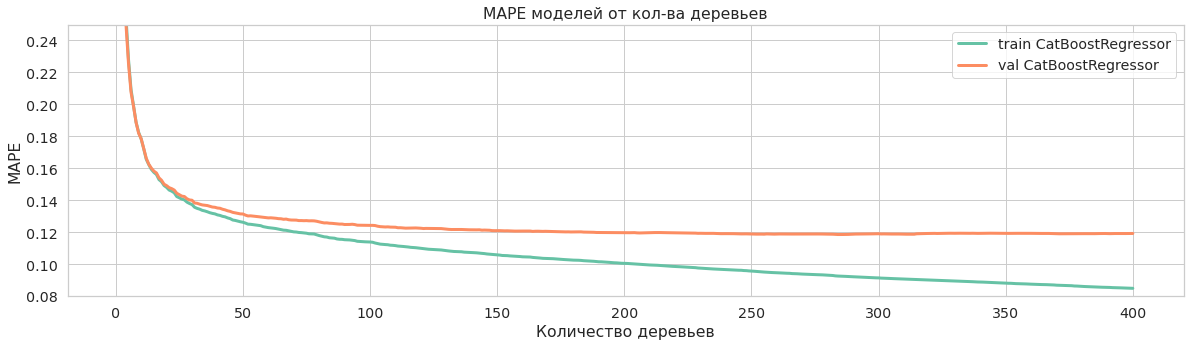

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(n_estimators_CatBoostRegressor_train)) + 1, n_estimators_CatBoostRegressor_train, 
         lw=3, label='train CatBoostRegressor')
plt.plot(np.arange(len(n_estimators_CatBoostRegressor)) + 1, n_estimators_CatBoostRegressor, 
         lw=3, label='val CatBoostRegressor')
plt.xlabel('Количество деревьев')
plt.ylabel('MAPE')
plt.title('MAPE моделей от кол-ва деревьев')
plt.ylim(0.08,0.25)
plt.legend()
plt.show()

Хотелось бы сказать, что давайте зафиксируем 300 деревьев и все, но на самом деле тут так нельзя. 1) метрика чуть-чуть, но становится лучше. Поэтому надо точно найти момент, когда у нас больше не будет улучшений(сделай дальше). 
2)базовый параметр равен 1000, не просто так же, так что хороший поаод по-лучше поискать данный параметр.

Выше я сделал, как мы делали раньше, но давайте ниже сделаем с помощью cv

In [ ]:
cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features=['zipcode'])
params = {'learning_rate':learning_rate,
         'eval_metric':'MAPE',
          "loss_function": "MAPE",
        'verbose':0}
scores = cv(cv_dataset,
            params,
            fold_count=5, 
            plot="True",
            iterations=4000,
            early_stopping_rounds=300, verbose=0)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.2917493528
bestIteration = 428

Training on fold [1/5]

bestTest = 0.2630242309
bestIteration = 1388

Training on fold [2/5]

bestTest = 0.2705403072
bestIteration = 2424

Training on fold [3/5]

bestTest = 0.2699360174
bestIteration = 1200

Training on fold [4/5]

bestTest = 0.2910262909
bestIteration = 2725



In [ ]:
n_estimators=len(scores)


In [ ]:
model = GridSearchCV(
    CatBoostRegressor(n_estimators=n_estimators,learning_rate=learning_rate,silent=True, 
                      random_state=1,cat_features=['zipcode'],eval_metric='MAPE'),
    param_grid={
        'max_depth': np.arange(3,11),
        'border_count':[128,254]
    },
    scoring='neg_mean_absolute_percentage_error',
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=1,  # насколько часто печатать сообщения
    n_jobs=-1  # кол-во параллельных процессов
)
model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f02705481d0>,
             n_jobs=-1,
             param_grid={'border_count': [128, 254],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [ ]:
best_params=model.best_params_
best_params

{'border_count': 128, 'max_depth': 6}

In [ ]:
#нарисуем примерный график зависимости модели от learning_rate, чтобы понимать в каком диапазоне искать
res_val=[]
res_train=[]
grid=np.logspace(-5,1.3,100)
for i in tqdm(grid):
    model=CatBoostRegressor(n_estimators=n_estimators,learning_rate=learning_rate,
                      silent=True,random_state=1,cat_features=['zipcode'],eval_metric='MAPE',**best_params,l2_leaf_reg=i)
    model.fit(X_train,y_train)
    
    predictions = model.predict(X_val)
    res_val.append(mape(y_val,predictions))
    
    predictions = model.predict(X_train)
    res_train.append(mape(y_train,predictions))

  0%|          | 0/100 [00:00<?, ?it/s]

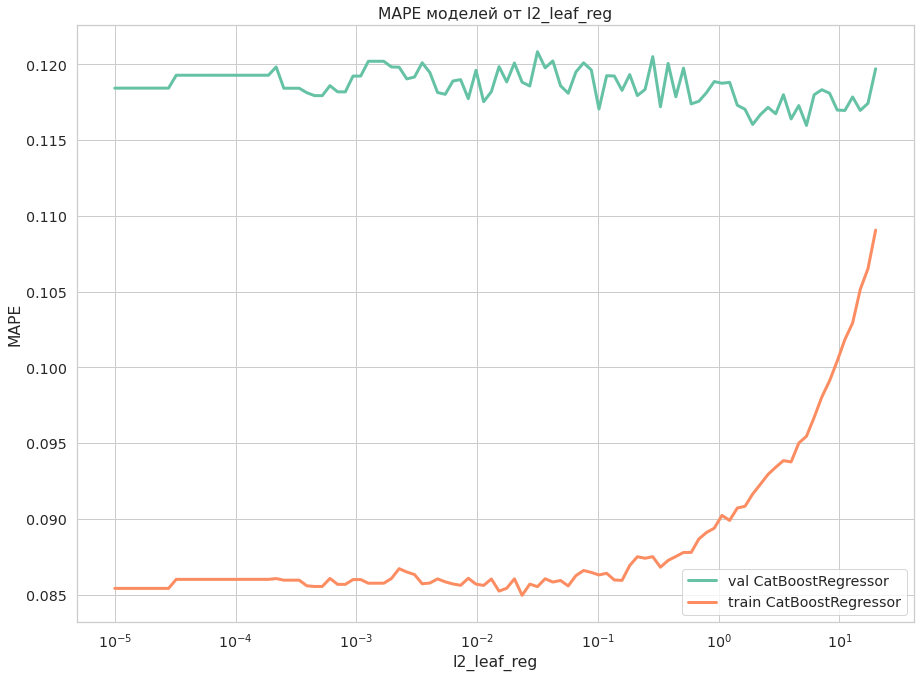

In [ ]:
plt.figure(figsize=(15, 11))
plt.plot(grid, res_val, 
         lw=3, label='val CatBoostRegressor')
plt.plot(grid, res_train, 
         lw=3, label='train CatBoostRegressor')
plt.xlabel('l2_leaf_reg')
plt.ylabel('MAPE')
plt.xscale("log") 
plt.title('MAPE моделей от l2_leaf_reg')
#plt.ylim(0.115,0.12)
plt.legend()
plt.show()

В какой-то момент мы видим проблему с обучением, то есть на train метрика резко ухудшается, а вот на val она около оптимальной. Но это нелогично, по-хорошему такого не должно быть. 

In [ ]:
%%time
model = RandomizedSearchCV(
    CatBoostRegressor(n_estimators=n_estimators,learning_rate=learning_rate,
                      silent=True,random_state=1,cat_features=['zipcode'],eval_metric='MAPE',**best_params),
    param_distributions={
        'l2_leaf_reg': np.logspace(-3,1,100000),
        #'random_strength':np.arange(0,20)
    },
    scoring='neg_mean_absolute_percentage_error',
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=1,  # насколько часто печатать сообщения
    n_jobs=-1,  # кол-во параллельных процессов,
    n_iter=100
)
model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 12.1 s, sys: 1.34 s, total: 13.4 s
Wall time: 16min 31s


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f025afb3550>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'l2_leaf_reg': array([1.00000000e-03, 1.00009211e-03, 1.00018423e-03, ...,
       9.99815808e+00, 9.99907900e+00, 1.00000000e+01])},
                   scoring='neg_mean_absolute_percentage_error', verbose=1)

In [ ]:
best_params_2=model.best_params_
best_params_2

{'l2_leaf_reg': 4.041253233982573}

Все что выше я сделал, это я посмотрел на каждое действие эвристического алгоритма поиска оптимальных параметров. Реализуем это в функции, которую будем запускать внутри цикла, где уже будем перебирать learning_rate. Также я понял в каком диапазоне мне стоит искать гиперпараметры, также пониманию этого помогли базовые значения у catboost.

**Давайте теперь сделаем цикл, где будем все это прогонять(сначала learning_rate и т.д.)**

In [ ]:
def search_opt(learning_rate):
    cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features=['zipcode'])
    params = {'learning_rate':learning_rate,
             'eval_metric':'MAPE',
              "loss_function": "MAPE",
            'verbose':0}
    scores = cv(cv_dataset,
                params,
                fold_count=5, 
                plot="True",
                iterations=1500,
                early_stopping_rounds=150, verbose=0)
    n_estimators=len(scores)#нашли кол-во деревьев
    print(n_estimators)
    
    model = GridSearchCV(
    CatBoostRegressor(n_estimators=n_estimators,learning_rate=learning_rate,silent=True, 
                      random_state=1,cat_features=['zipcode'],eval_metric='MAPE'),
    param_grid={
        'max_depth': np.arange(3,11),
        #'border_count':[128,254]
    },
    scoring='neg_mean_absolute_percentage_error',
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=1,  # насколько часто печатать сообщения
    n_jobs=-1  # кол-во параллельных процессов
    )
    model.fit(X_train, y_train)
    best_params=model.best_params_
    #нашли макс глубину
    print(best_params)
    
    model = RandomizedSearchCV(
        CatBoostRegressor(n_estimators=n_estimators,learning_rate=learning_rate,
                          silent=True,random_state=1,cat_features=['zipcode'],eval_metric='MAPE',**best_params),
        param_distributions={
            'l2_leaf_reg': np.logspace(-3,1,100000),
            #'random_strength':np.arange(0,20)
        },
        scoring='neg_mean_absolute_percentage_error',
        cv=5,  # разбиение выборки на 5 фолдов
        verbose=1,  # насколько часто печатать сообщения
        n_jobs=-1,  # кол-во параллельных процессов,
        n_iter=100
    )
    model.fit(X_train, y_train)
    best_params_2=model.best_params_
    #нашли регуляризацию
    print(best_params_2)
    
    model=CatBoostRegressor(n_estimators=n_estimators,learning_rate=learning_rate,
                          silent=True,random_state=1,cat_features=['zipcode'],eval_metric='MAPE',**best_params,**best_params_2)
    model.fit(X_train,y_train)
    prediction=mape(y_val,model.predict(X_val))
    print(prediction)
    return best_params,best_params_2,prediction

In [ ]:
learning_rate=np.arange(0.05,0.3,0.01)
first_params=[]
second_params=[]
res_prediction=[]
best_res_prediction=np.inf

k=0
learning_rate=0.1
while True:
    best_params,best_params_2,prediction=search_opt(learning_rate)
    first_params.append(best_params)
    second_params.append(second_params)
    res_prediction.append(prediction)
    
    k+=1
    print('k =',k)
    if (np.abs(prediction-best_res_prediction))<=1e-3 or k>=10:
        best_res_prediction=prediction
        break
    if (best_res_prediction>prediction):
        best_res_prediction=prediction
    learning_rate-=0.01

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.297952546
bestIteration = 440

Training on fold [1/5]

bestTest = 0.285948758
bestIteration = 1480

Training on fold [2/5]

bestTest = 0.2797922937
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.3033893349
bestIteration = 1361

Training on fold [4/5]

bestTest = 0.2896709907
bestIteration = 1090

1500
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'max_depth': 6}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'l2_leaf_reg': 2.030079637737623}
0.11411873504851924
k = 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.289714936
bestIteration = 231

Training on fold [1/5]

bestTest = 0.2876433572
bestIteration = 1487

Training on fold [2/5]

bestTest = 0.2816185381
bestIteration = 1352

Training on fold [3/5]

bestTest = 0.2864081985
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.2947012749
bestIteration = 513

1500
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'max_depth': 7}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'l2_leaf_reg': 3.988742571253845}
0.11272737979954625
k = 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.3188611456
bestIteration = 950

Training on fold [1/5]

bestTest = 0.2818335005
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.3022277021
bestIteration = 1298

Training on fold [3/5]

bestTest = 0.2918187603
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.3004195909
bestIteration = 1252

1500
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'max_depth': 7}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'l2_leaf_reg': 5.448505112856933}
0.113316186610225
k = 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.2896122672
bestIteration = 577

Training on fold [1/5]

bestTest = 0.2849218613
bestIteration = 1432

Training on fold [2/5]

bestTest = 0.3020015798
bestIteration = 1471

Training on fold [3/5]

bestTest = 0.2895234765
bestIteration = 1496

Training on fold [4/5]

bestTest = 0.3012586457
bestIteration = 454

1500
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'max_depth': 7}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'l2_leaf_reg': 3.1923833800490824}
0.11315015685686636
k = 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.2976413873
bestIteration = 1465

Training on fold [1/5]

bestTest = 0.2907621576
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.3056794174
bestIteration = 1411

Training on fold [3/5]

bestTest = 0.3155498872
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.2995760269
bestIteration = 1257

1500
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'max_depth': 8}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Теперь мы можем задать итоговую нашу модель

In [28]:
model=CatBoostRegressor(n_estimators=1500,l2_leaf_reg=3.988742571253845,learning_rate=0.075,
                          silent=True,random_state=1,cat_features=['zipcode'],eval_metric='MAPE',max_depth=7,border_count=124)
model.fit(X_train,y_train)

In [29]:
mape(y_val,model.predict(X_val))*100

11.207689381683275

Именно данная реализация дала максимальный результат на 30 процентой части теста. **10.865**. Ее параметры около оптимальных, пока что лучший кандидат.

In [35]:
def do_test_file(model):
    predictions_test=model.predict(X_test)
    df_test_res=pd.DataFrame(zip(np.arange(1,len(predictions_test)+1),predictions_test))
    df_test_res.columns=['index','price']
    df_test_res=df_test_res.set_index('index')
    df_test_res.to_csv("test_res.csv")

In [36]:
do_test_file(model)

Последний поиск параметров в catboost

In [ ]:
model = RandomizedSearchCV(
        CatBoostRegressor(silent=True,random_state=1,cat_features=['zipcode'],eval_metric='MAPE'),
        param_distributions={
            'n_estimators': np.arange(1300,1700),
            'l2_leaf_reg': np.logspace(-1,1,100000),
            'learning_rate':np.linspace(0.07,0.11,1000000),
            'max_depth':[6,7,8],
            'border_count':np.arange(100,150)
        },
        scoring='neg_mean_absolute_percentage_error',
        cv=5,  # разбиение выборки на 5 фолдов
        verbose=1,  # насколько часто печатать сообщения
        n_jobs=-1,  # кол-во параллельных процессов,
        n_iter=300
    )
model.fit(X_train_all, y_train_all)
model.best_params_, model.best_score_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


Получил оптимальные параметры, подставил вниз их

In [45]:
model=CatBoostRegressor(n_estimators=1390,l2_leaf_reg=3.6599540652461506,learning_rate=0.07227040227040228,
                          silent=True,random_state=1,cat_features=['zipcode'],eval_metric='MAPE',max_depth=7,border_count=145)
model.fit(X_train_all,y_train_all)

In [46]:
do_test_file(model)

На 30 процентной части теста это дало 10.92.Хороший вариант для возможного стеккинга, но уступает моему лучшему 10.86

**Найдем опт параметры для lightboost**

In [25]:
from lightgbm import Dataset
from lightgbm import cv as cv_light
X_train_lgbm=X_train.copy()
X_train_lgbm['date']=X_train_lgbm['date'].astype('int')#или вообще уберем дату, надо будет попробовать

X_val_lgbm=X_val.copy()
X_val_lgbm['date']=X_val_lgbm['date'].astype('int')

X_test_lgbm=X_test.copy()
X_test_lgbm['date']=X_test_lgbm['date'].astype('int')

In [21]:
learning_rate=0.1
regressor = LGBMRegressor(n_estimators=100, random_state=42, metric='mape',learning_rate=learning_rate)
regressor.fit(X_train_lgbm, y_train)
predictions = regressor.predict(X_val_lgbm)
mape(y_val,predictions)

0.12406768326378935

In [131]:
model = RandomizedSearchCV(
    LGBMRegressor(n_estimators=100,learning_rate=learning_rate, 
                      random_state=1,metric='mape'),
    param_distributions={
        'max_depth': np.arange(3,10),
        "min_child_samples ": range(15, 25),
        'num_leaves' : range(10,50)
    },
    scoring='neg_mean_absolute_percentage_error',
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=1,  # насколько часто печатать сообщения
    n_jobs=-1,  # кол-во параллельных процессов
    n_iter=50
    )
model.fit(X_train_lgbm, y_train,categorical_feature=['zipcode'])
best_params=model.best_params_
#нашли макс глубину
print(best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'num_leaves': 18, 'min_child_samples ': 18, 'max_depth': 7}


In [136]:
def search_opt_light(learning_rate):
    cv_dataset = Dataset(data=X_train_lgbm,
                  label=y_train,
                  categorical_feature =['zipcode'])
    params = {'learning_rate':learning_rate,
                'metric':'mape',
                "loss_function": "mape",
                'verbose':0}
    scores = cv_light(params = params,
        train_set = cv_dataset,
        num_boost_round=1500,
        stratified=False,
        nfold = 5,
        verbose_eval=0,
        early_stopping_rounds=100)
    n_estimators=np.argmin(scores['mape-mean'])
    print(n_estimators)
    
    model = RandomizedSearchCV(
        LGBMRegressor(n_estimators=n_estimators,learning_rate=learning_rate, 
                        random_state=1,metric='mape'),
        param_distributions={
            'max_depth': np.arange(3,10),
            "min_child_samples ": range(15, 25),
            'num_leaves' : range(10,50)
        },
        scoring='neg_mean_absolute_percentage_error',
        cv=5,  # разбиение выборки на 5 фолдов
        verbose=1,  # насколько часто печатать сообщения
        n_jobs=-1,  # кол-во параллельных процессов
        n_iter=100
        )
    model.fit(X_train_lgbm, y_train,categorical_feature=['zipcode'])
    best_params=model.best_params_
    #нашли макс глубину
    print(best_params)
    
    model = RandomizedSearchCV(
        LGBMRegressor(n_estimators=n_estimators,learning_rate=learning_rate,silent=True, 
                      random_state=1,metric='mape',**best_params),
        param_distributions={
            'reg_alpha ': np.logspace(-3,1,100000),
            'reg_lambda ':np.logspace(-3,1,100000)
        },
        scoring='neg_mean_absolute_percentage_error',
        cv=5,  # разбиение выборки на 5 фолдов
        verbose=1,  # насколько часто печатать сообщения
        n_jobs=-1,  # кол-во параллельных процессов,
        n_iter=100
    )
    model.fit(X_train_lgbm, y_train,categorical_feature=['zipcode'])
    best_params_2=model.best_params_
    #нашли регуляризацию
    print(best_params_2)
    
    model=LGBMRegressor(n_estimators=n_estimators,learning_rate=learning_rate,silent=True, 
                      random_state=1,metric='mape',**best_params,**best_params_2)
    model.fit(X_train_lgbm,y_train,categorical_feature=['zipcode'])
    prediction=mape(y_val,model.predict(X_val_lgbm))
    print(prediction)
    return best_params,best_params_2,prediction

In [ ]:
first_params=[]
second_params=[]
res_prediction=[]
best_res_prediction=np.inf

k=-1
learning_rate=0.3
while True:
    best_params,best_params_2,prediction=search_opt_light(learning_rate)
    first_params.append(best_params)
    second_params.append(second_params)
    res_prediction.append(prediction)
    
    k+=1
    print('k =',k)
    print(learning_rate)
    if k>=29:
        break
    if (best_res_prediction>prediction):
        best_res_prediction=prediction
    learning_rate-=0.01

In [26]:
model=LGBMRegressor(num_leaves=44, min_child_samples=15, max_depth=9,silent=True, 
                      random_state=1,metric='mape',reg_lambda=9.988953586687582,
                     reg_alpha =0.05996499184822633,learning_rate=0.019999999999999858)
model.fit(X_train_lgbm,y_train,categorical_feature=['zipcode'])

LGBMRegressor(learning_rate=0.019999999999999858, max_depth=9, metric='mape',
              min_child_samples=15, num_leaves=44, random_state=1,
              reg_alpha=0.05996499184822633, reg_lambda=9.988953586687582)

In [27]:
predictions_test=model.predict(X_test_lgbm)
df_test_res=pd.DataFrame(zip(np.arange(1,len(predictions_test)+1),predictions_test))
df_test_res.columns=['index','price']
df_test_res=df_test_res.set_index('index')
df_test_res.to_csv("test_res.csv")

**Мини-итог**:вообще я хотел использовать lightboost для совместного стеккинга с catboost, но разница в метрики между ними достаточно большая, скорее всего я не нашел самые оптимальные параметры lightboost(хотя из-за того, что он считает быстрее всех, я смог сделать полноценный эвристический подход к настройке гиперпараметров с шагом learning_rate всего 0.01). Но не получилось тут найти очень оптимальные параметры

**Вывод**. В данной задаче было очень важно поиграться с признаками. Но не только создать новые, как например поворот координат на 45 градусов или разница между двумя датами. Так и отбор наиболее оптимальных признаков. Также тут было очень важно найти нужные параметры catboost, которые искались очень долго, так как cv требовало много ресурсов. Еще надо отметить, что огромный плюс, что catboost умеет потрясающе работать с категориальными признаками,поэтому его было очень удобно и полезно работать, так как у нас был категориальный признак, который надо было хорошо обработать. В итоге добавлю, что можно было улучшить многие вещи (например поработать с выбросами или сделать стеккинг из разных бустов, но не хватило времени для реализации всех этих планов) 